In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model

seed = 42

DATASET_NAME = 'dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))
target_array = df[TARGET_FEATURE]

df.drop(columns=[TARGET_FEATURE], inplace=True)
# df.drop(columns=['Type', 'GeneSymbol', 'VariantLength', 'VariantLengthDifference'], inplace=True)

ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = ['GeneSymbol']
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference', "OriginGermline"]

pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

2025-11-12 14:57:39.183 | INFO     | gene_variation_effects.config:<module>:11 - PROJ_ROOT path is: /Users/jeffbrin/Desktop/gene-variation-effects-ml


In [2]:
# Split the data
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1
GROUP_COLUMN = 'group'

training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

def split_multi_features_from_data_output(data: np.ndarray):
    data_df = pd.DataFrame(data, columns=df.columns)
    data_df = pipeline.split_multi_value_feature(data_df, 'GeneSymbol')
    data_df[GROUP_COLUMN] = data_df.index.astype(int)

    return data_df.to_numpy(), data_df.columns

training_data, columns = split_multi_features_from_data_output(training_data)
validation_data, _ = split_multi_features_from_data_output(validation_data)
test_data, _ = split_multi_features_from_data_output(test_data)


In [3]:
# Merge rows which were split earlier on gene symbol
def combine_duplicated_genesymbol_rows(data: np.ndarray, genesymbol_column_index: int) -> tuple[torch.Tensor, list[str]]:
    columns = list(range(data.shape[1]))
    columns[genesymbol_column_index] = 'GeneSymbol'
    columns[-1] = GROUP_COLUMN
    grouped_df = pd.DataFrame(data, columns=columns).groupby(by=[GROUP_COLUMN])
    gene_symbol_lists = grouped_df['GeneSymbol'].apply(lambda g: ";".join(str(x) for x in g))
    output_df = grouped_df.mean()
    encoded_gene_lists, unique_gene_lists = pd.factorize(gene_symbol_lists)

    output_df['GeneSymbol'] = encoded_gene_lists
    columns.remove(GROUP_COLUMN)
    return torch.Tensor(output_df[columns].to_numpy()), unique_gene_lists

# Fit pipeline and transform data
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)

# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]

transformed_X_training, unique_gene_lists_training = combine_duplicated_genesymbol_rows(transformed_X_training, embedding_features_indices[0])
transformed_X_validation, unique_gene_lists_validation = combine_duplicated_genesymbol_rows(feature_processor.transform(validation_data).astype(float), embedding_features_indices[0])
transformed_X_test, unique_gene_lists_testing = combine_duplicated_genesymbol_rows(feature_processor.transform(test_data).astype(float), embedding_features_indices[0])

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [4]:
# TODO: Idk if I did something weird here
# TODO: Move to pipeline
# Getting input sizes for embedding layer
embedding_processor = feature_processor.named_transformers_['high_cardinality']
label_encoder = embedding_processor.named_steps['label_encode']

extra_cat_for_potential_unknown = 1 if label_encoder.handle_unknown == 'use_encoded_value' else 0
if hasattr(label_encoder, "categories_"):
    embedding_input_sizes = [cat.size + extra_cat_for_potential_unknown for cat in label_encoder.categories_]
else:
    embedding_input_sizes = []

In [5]:
# We only have one embedding input size right now, since we're doing this by hand anyways we can probably hard-code each one
# going forward. Maybe there is a way to automate this.
HIDDEN_SIZES = [256, 128, 64]
DROPOUT = 0
if len(embedding_input_sizes) > 0:
    GENE_LABELS_EMBEDDING_SIZE = int(embedding_input_sizes[0] ** 0.5)
    embedding_dimension_mapping = np.array([[embedding_input_sizes[0], GENE_LABELS_EMBEDDING_SIZE]])
else:
    embedding_dimension_mapping = np.array([])


2025-11-12 14:59:52.837 | INFO     | gene_variation_effects.modeling.train:run_training_loop:128 - Epoch 1: accuracy=0.5010
2025-11-12 14:59:52.860 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 1: validation accuracy=0.4971
2025-11-12 14:59:52.860 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130 - Epoch 1: validation loss=0.6919
2025-11-12 14:59:53.037 | INFO     | gene_variation_effects.modeling.train:run_training_loop:128 - Epoch 2: accuracy=0.4942
2025-11-12 14:59:53.037 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 2: validation accuracy=0.5049
2025-11-12 14:59:53.037 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130 - Epoch 2: validation loss=0.6906
2025-11-12 14:59:53.234 | INFO     | gene_variation_effects.modeling.train:run_training_loop:128 - Epoch 3: accuracy=0.5204
2025-11-12 14:59:53.235 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129

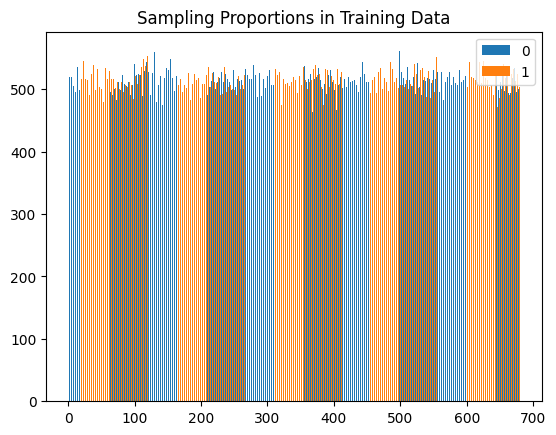

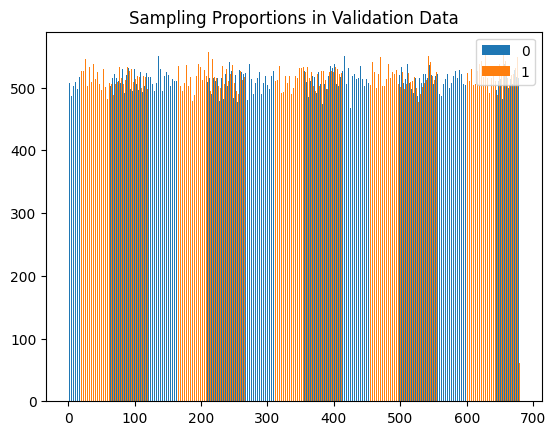

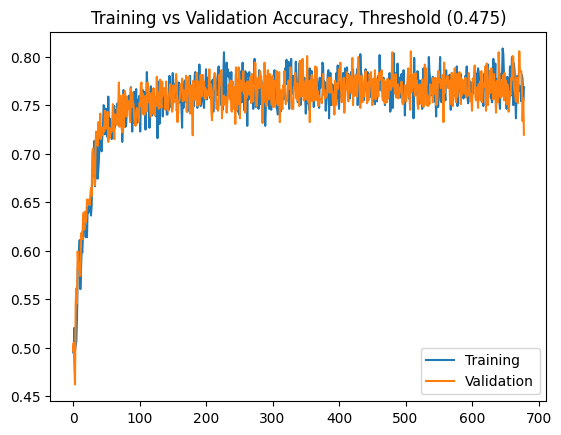

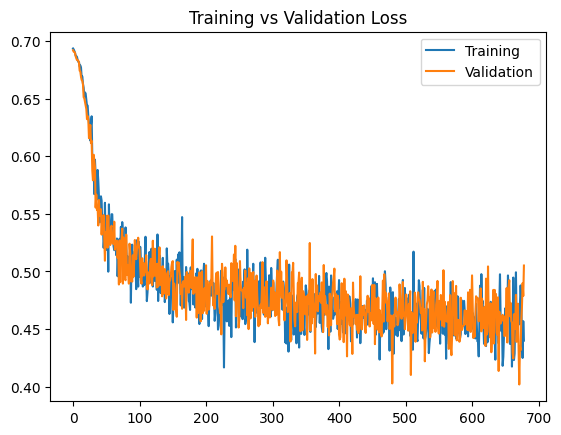

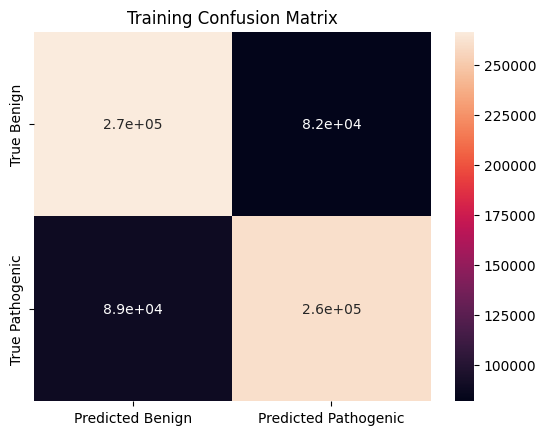

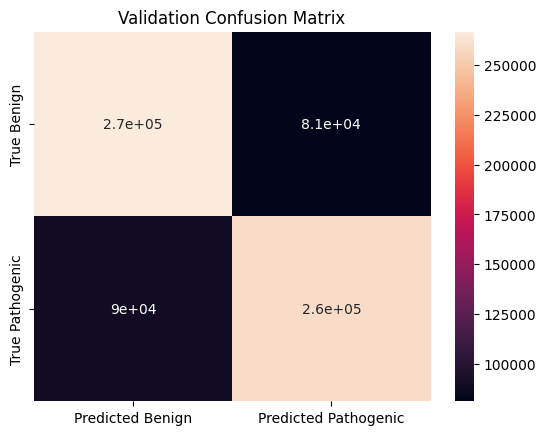

<Figure size 640x480 with 0 Axes>

In [6]:
from gene_variation_effects.modeling.utils import logits_to_prediction

# Subtracting 1 from shape since shape here includes the tag used to join gene symbols
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

BATCH_SIZE = 1028
PATIENCE = 3000
POSITIVE_THRESHOLD = 0.475

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# TODO: Move confusion matrix out of training loop
optimal_model_dict, training_losses, val_losses, training_prediction_logits, val_prediction_logits, \
    dataloader_training_targets, dataloader_val_targets = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, 
    validation_target_array, unique_gene_lists_training, unique_gene_lists_validation, embedding_features_indices, patience=PATIENCE, positive_threshold=POSITIVE_THRESHOLD,
    positive_class_loss_weight=torch.Tensor([1]),
    optimizer=optimizer, visualize=True)
torch.save(optimal_model_dict, "../models/model.pth")

plt.plot(training_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
plt.clf()

NEGATIVE_TRUTH = "True Benign"
POSITIVE_TRUTH = "True Pathogenic"
NEGATIVE_PREDICTION = "Predicted Benign"
POSITIVE_PREDICTION = "Predicted Pathogenic"
def generate_confusion_matrix(predictions, targets):
    cm_indices = [NEGATIVE_TRUTH, POSITIVE_TRUTH]
    cm_cols = [NEGATIVE_PREDICTION, POSITIVE_PREDICTION]
    confusion_matrix = metrics.confusion_matrix(targets, predictions)
    return pd.DataFrame(confusion_matrix, index = cm_indices, columns = cm_cols)


all_training_predictions = logits_to_prediction(torch.Tensor(training_prediction_logits), POSITIVE_THRESHOLD)
all_val_predictions = logits_to_prediction(torch.Tensor(val_prediction_logits), POSITIVE_THRESHOLD)

training_confusion_matrix_df = generate_confusion_matrix(all_training_predictions, dataloader_training_targets)
val_confusion_matrix_df = generate_confusion_matrix(all_val_predictions, dataloader_val_targets)
# plt.matshow(training_confusion_matrix_df)
# plt.matshow(val_confusion_matrix_df)
sn.heatmap(training_confusion_matrix_df, annot=True)
plt.title("Training Confusion Matrix")
plt.show()
plt.clf()
sn.heatmap(val_confusion_matrix_df, annot=True)
plt.title("Validation Confusion Matrix")
plt.show()
plt.clf()

# TODO: Add axis titles

0
1
2
3
4
5
6
7
8
9


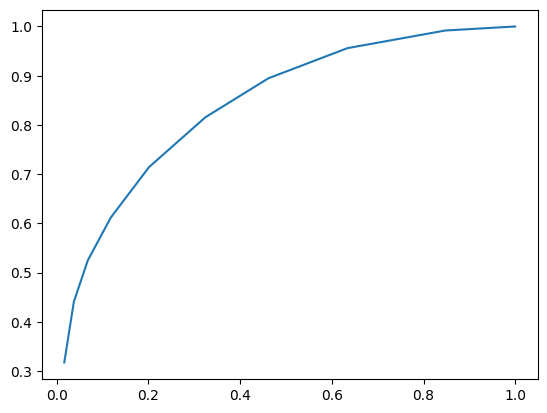

0
1
2
3
4
5
6
7
8
9


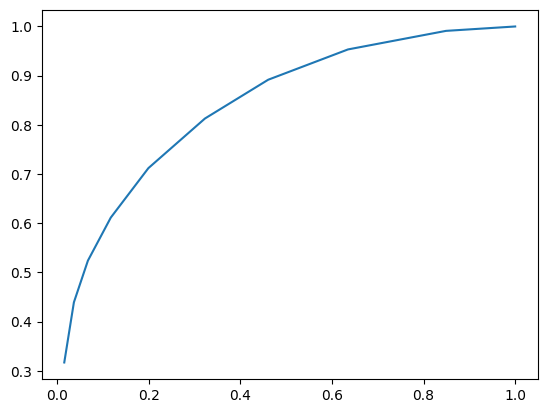

In [ ]:
def generate_roc_curve(prediction_logits, targets):
    AXIS_STEPS = 10
    points = []
    for threshold_pct in range(AXIS_STEPS):
        print(threshold_pct)
        threshold = threshold_pct / AXIS_STEPS
        predictions = logits_to_prediction(torch.Tensor(prediction_logits), threshold)
        confusion_matrix = generate_confusion_matrix(predictions, targets)
        true_positive_rate = confusion_matrix[POSITIVE_PREDICTION][POSITIVE_TRUTH] / sum(confusion_matrix.loc[POSITIVE_TRUTH])
        false_positive_rate = confusion_matrix[POSITIVE_PREDICTION][NEGATIVE_TRUTH] / sum(confusion_matrix.loc[NEGATIVE_TRUTH])

        point = (false_positive_rate, true_positive_rate)
        points.append(point)
    return points

training_roc_curve = generate_roc_curve(training_prediction_logits, dataloader_training_targets)
plt.plot([p[0] for p in training_roc_curve], [p[1] for p in training_roc_curve])
plt.show()
val_roc_curve = generate_roc_curve(val_prediction_logits, dataloader_val_targets)
plt.plot([p[0] for p in val_roc_curve], [p[1] for p in val_roc_curve])
plt.show()



    

In [8]:
# The proportion of predicted pathogenic which are correct
precision = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df['Predicted Pathogenic'])
# Proportion of actual pathogenic variants which were predicted correctly
recall = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df.loc['True Pathogenic'])
# Proportion of actual benign which were predicted correctly
specificity = training_confusion_matrix_df['Predicted Benign']['True Benign'] / sum(training_confusion_matrix_df.loc['True Benign'])

print(precision)
print(recall)
print(specificity)

0.760796041986717
0.7456732448230653
0.7651043668297608


In [9]:
# Recreate the model structure
model.load_state_dict(torch.load("../models/model.pth"))

<All keys matched successfully>

0
1
2
3
4
5
6
7
8
9


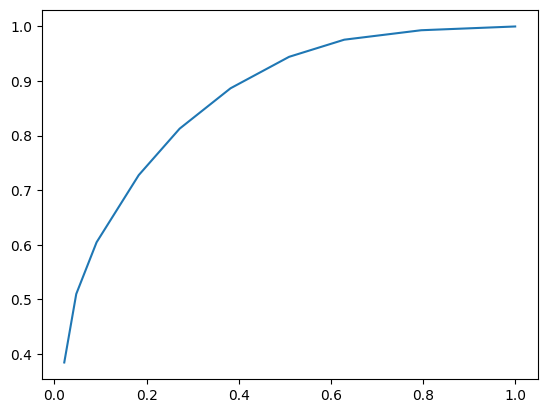

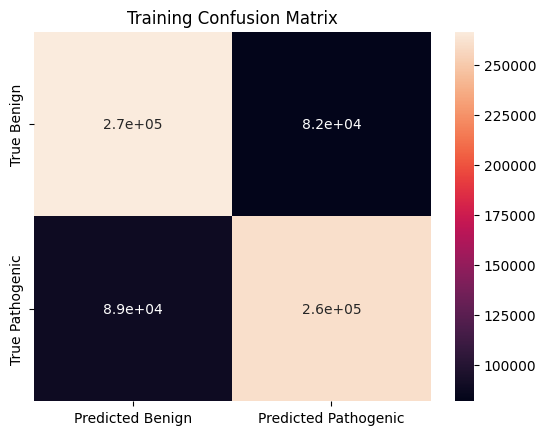

<Figure size 640x480 with 0 Axes>

In [ ]:
avg_loss, accuracy, predictions, targets = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices, unique_gene_lists_testing)

roc_curve = generate_roc_curve(predictions, targets)
plt.plot([p[0] for p in roc_curve], [p[1] for p in roc_curve])
plt.show()

all_test_predictions = logits_to_prediction(torch.Tensor(predictions), POSITIVE_THRESHOLD)
test_confusion_matrix_df = generate_confusion_matrix(all_test_predictions, targets)
# plt.matshow(training_confusion_matrix_df)
# plt.matshow(val_confusion_matrix_df)
sn.heatmap(training_confusion_matrix_df, annot=True)
plt.title("Testing Confusion Matrix")
plt.show()
plt.clf()